In [1]:
!pip install keras --upgrade
!pip uninstall ngdlm
!pip install git+https://github.com/AI-Guru/ngdlm.git

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.2.4)
Uninstalling ngdlm-0.0.2rc1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/ngdlm-0.0.2rc1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/ngdlm/*
Proceed (y/n)? y
  Successfully uninstalled ngdlm-0.0.2rc1
  Cloning https://github.com/AI-Guru/ngdlm.git to /tmp/pip-req-build-a2xp37i0
  Running setup.py bdist_wheel for ngdlm ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-oed20lvx/wheels/93/06/27/e156acb49f475c364c3c9fa4ad4ab7bfa38808bff5bf9c4647
Successfully built ngdlm


In [2]:
from keras import models, layers, optimizers
from ngdlm import models as ngdlmodels
from ngdlm import utils as ngdlmutils
from keras.datasets import mnist
import numpy as np

Using TensorFlow backend.


In [0]:
# parameters
latent_dim = 100
input_shape = (28,28,1)

# generator
generator = models.Sequential()
generator.add(layers.Dense(256, input_dim=latent_dim)) # takes input shape and maps it to 256 features
generator.add(layers.LeakyReLU(alpha=0.2))
generator.add(layers.BatchNormalization(momentum=0.8)) # you can do normalisation inside a neural network

generator.add(layers.Dense(512)) # we're upsampling here
generator.add(layers.LeakyReLU(alpha=0.2))
generator.add(layers.BatchNormalization(momentum=0.8))

generator.add(layers.Dense(1024))
generator.add(layers.LeakyReLU(alpha=0.2))
generator.add(layers.BatchNormalization(momentum=0.8))

# this layer goes down in size a bit to our input image shape
generator.add(layers.Dense(np.prod(input_shape),activation='tanh')) # we use tanh because of leaky relu? tanh goes from -1 to 1
generator.add(layers.Reshape(input_shape))
              
# we don't need to bother compiling here, because in the generator stage we don't need an optimizer or a loss at this stage
generator.predict(np.random.random((1,latent_dim)))[0]



# discriminator
discriminator = models.Sequential()
discriminator.add(layers.Flatten(input_shape=input_shape))
discriminator.add(layers.Dense(512))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dense(256))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dense(1,activation='sigmoid'))

# we now have to compile the discriminator because we want to have an optimizer and a loss
discriminator.compile(
    optimizer=optimizers.Adam(0.0002,0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [4]:
# import our data, normalize it, and make it the right dimensions for our GANs
(x_input_train,_),(_,_) = mnist.load_data()
x_input_train = x_input_train / 127.5-1.0
x_input_train = np.expand_dims(x_input_train,axis=3)
print(x_input_train.shape)

(60000, 28, 28, 1)


In [5]:
# compile our model together with the generator and discriminator
gan = ngdlmodels.GAN(generator=generator,discriminator=discriminator)
gan.compile(
    optimizer = optimizers.Adam(0.0002,0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
gan.summary()

Generator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


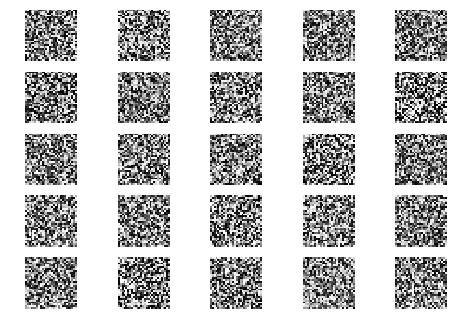

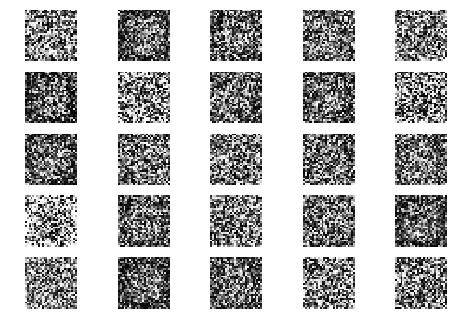

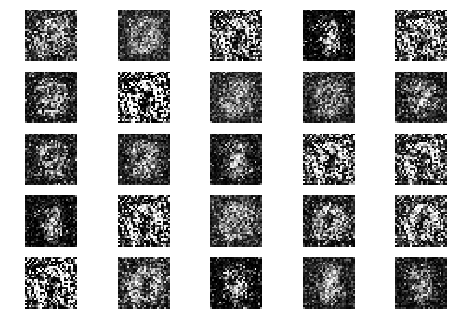

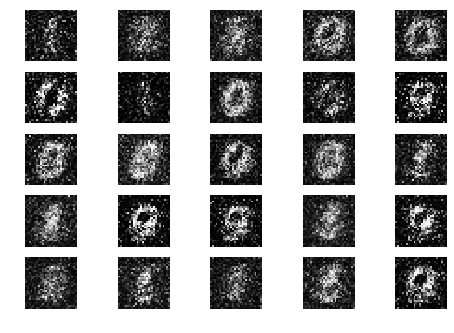

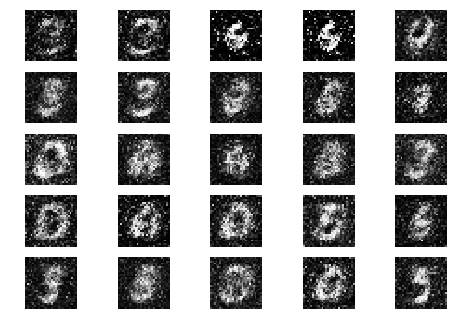

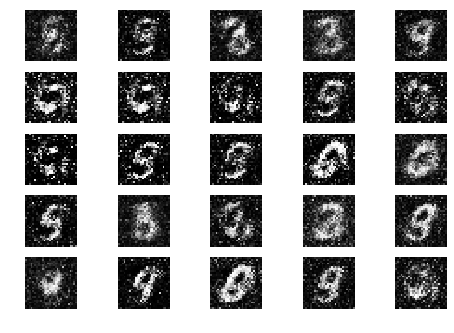

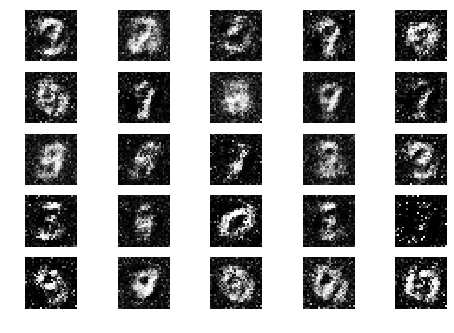

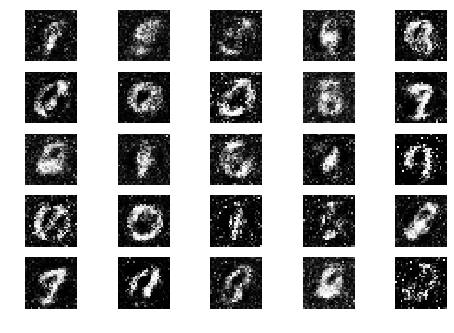

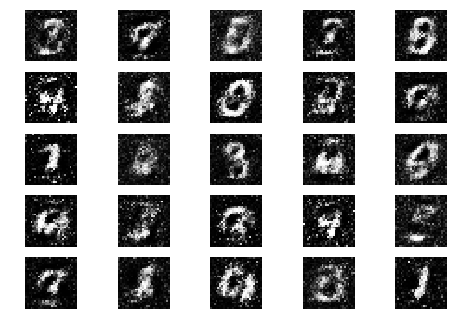

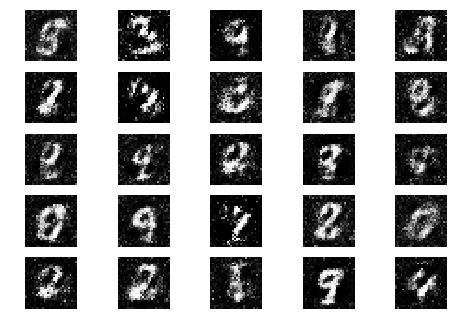

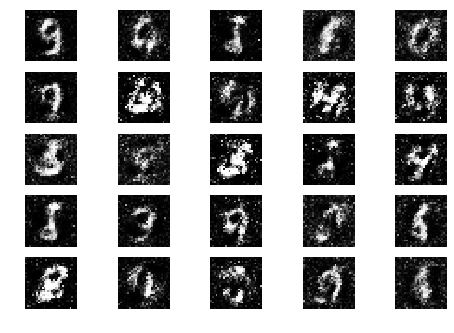

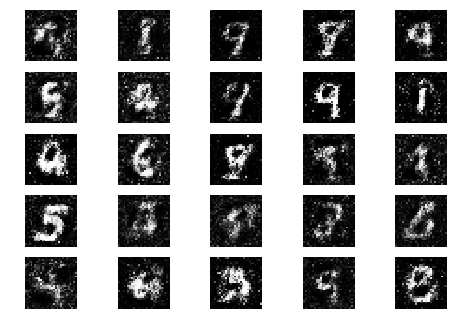

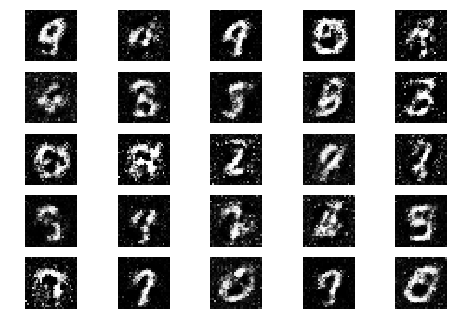

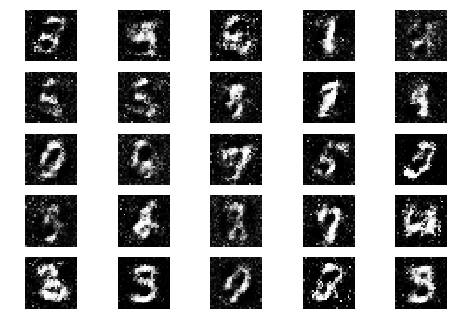

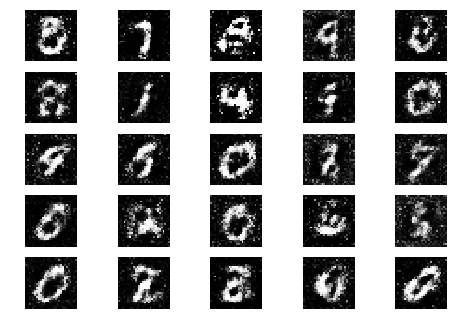

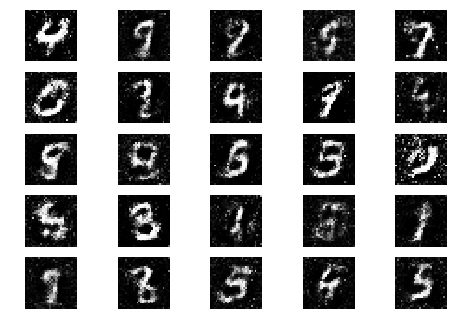

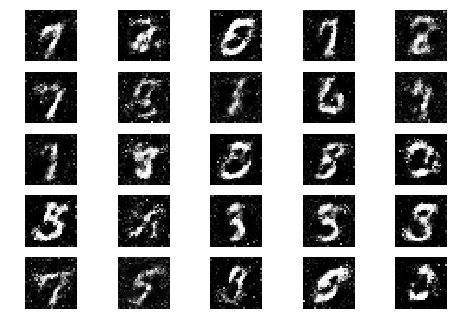

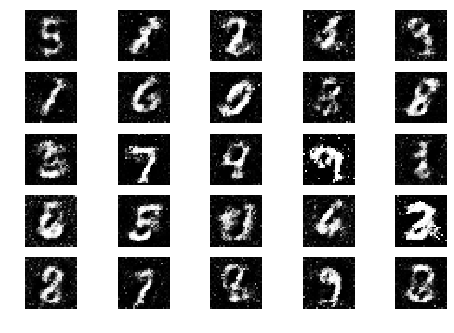

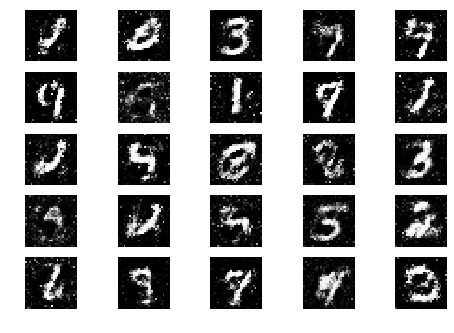

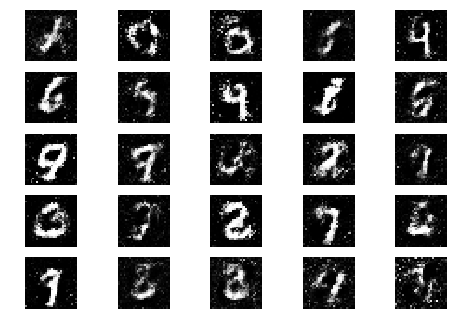

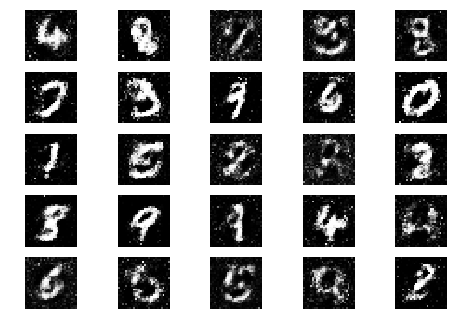

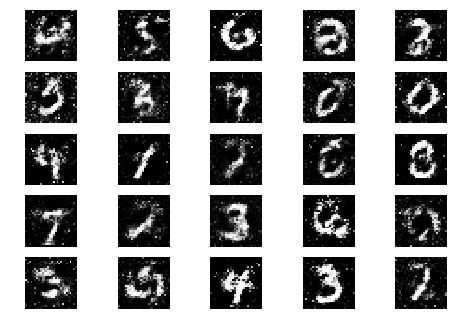

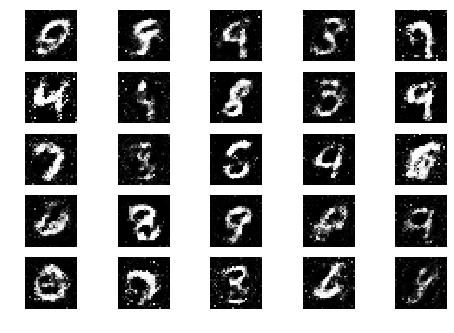

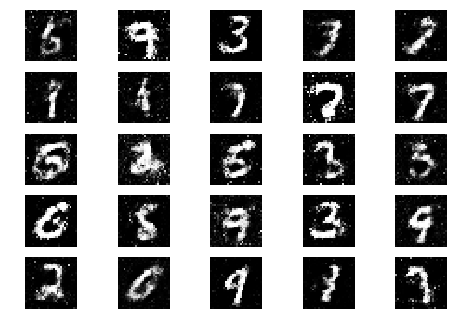

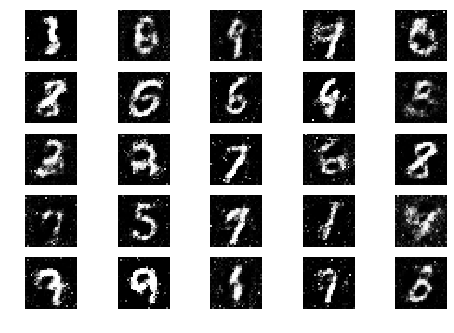

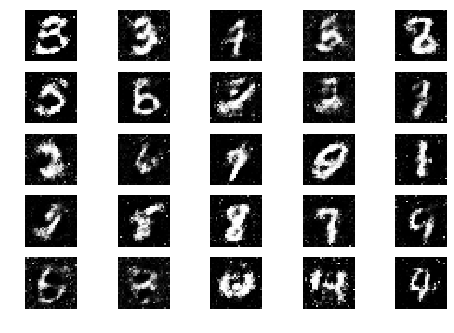

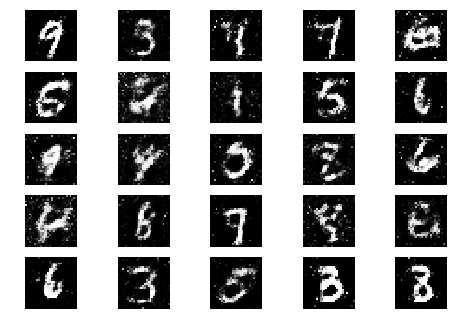

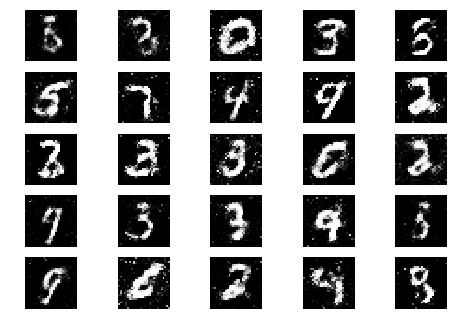

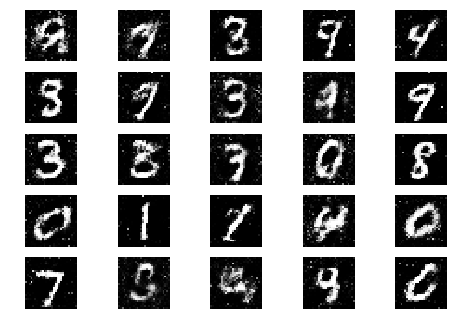

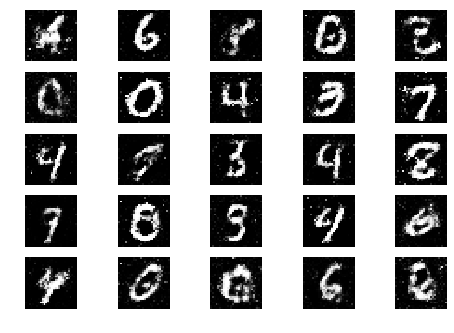

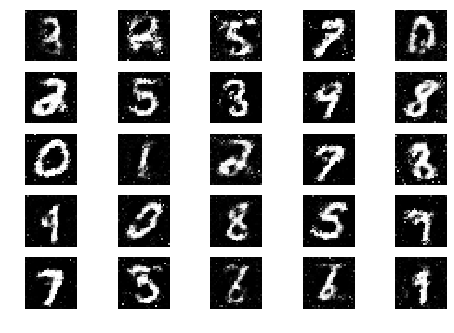

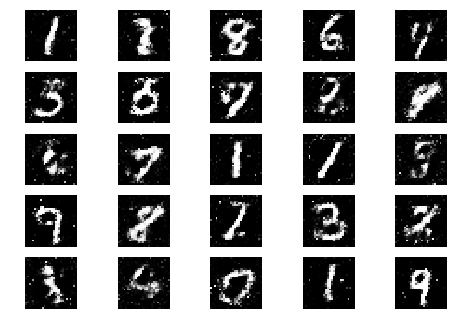

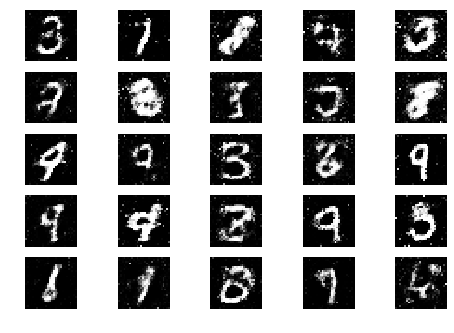

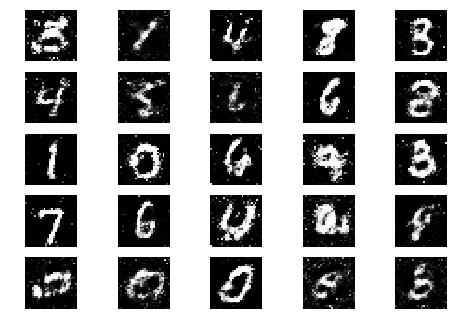

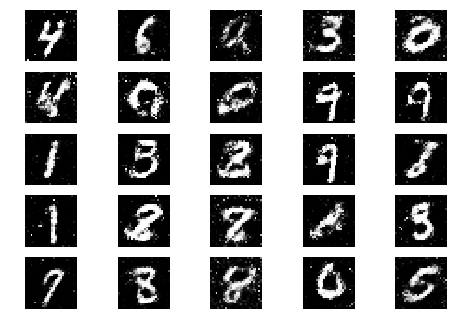

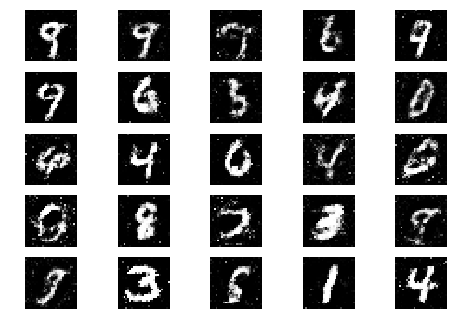

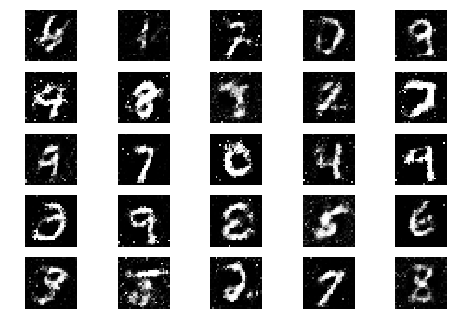

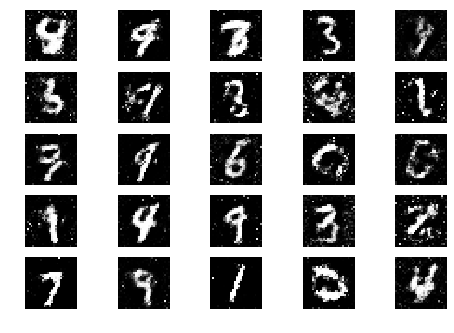

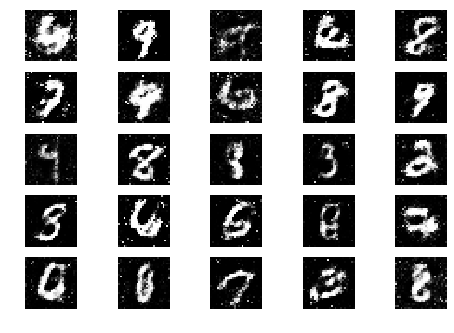

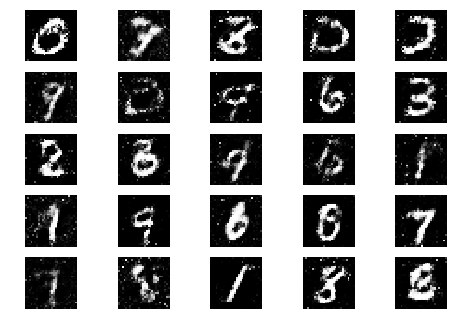

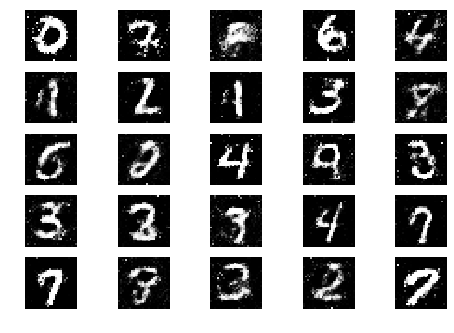

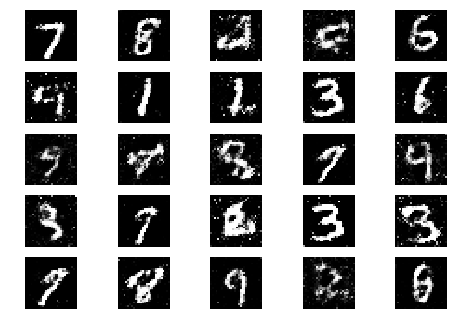

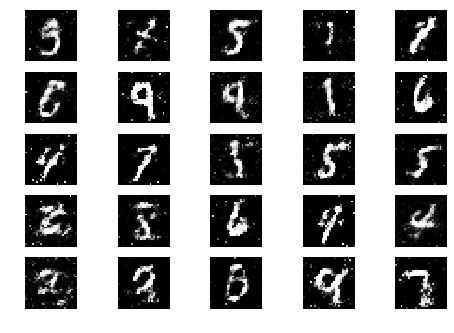

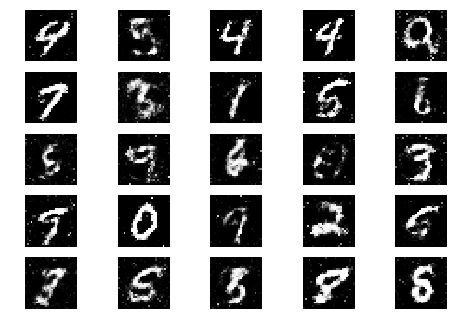

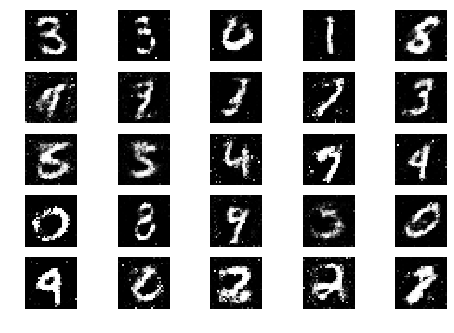

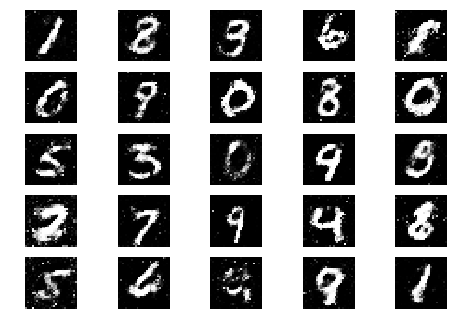

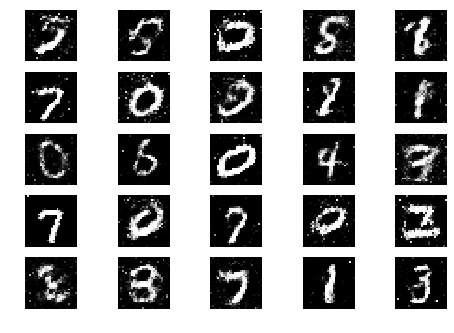

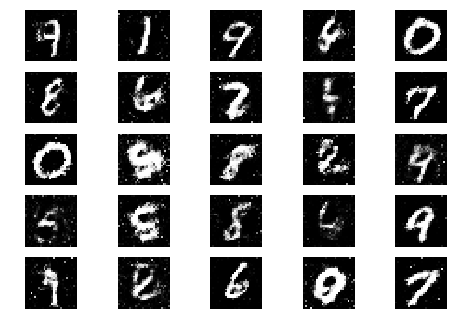

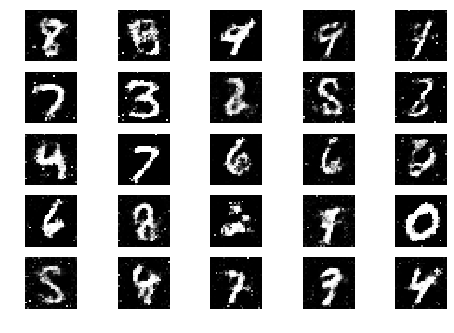

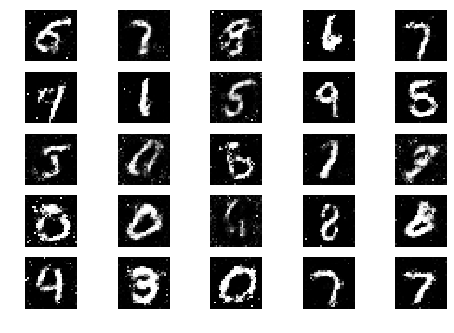

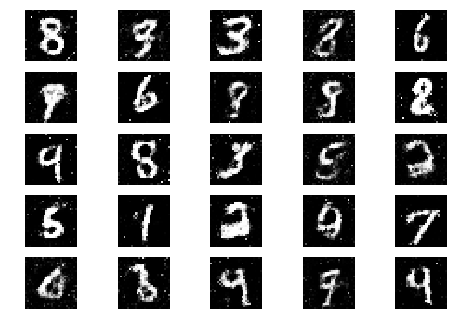

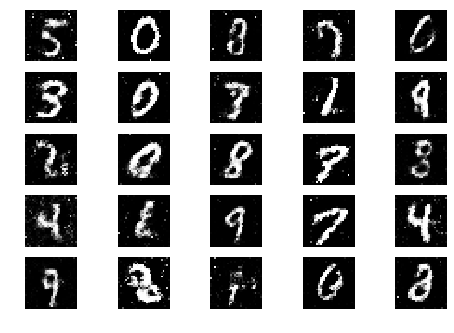

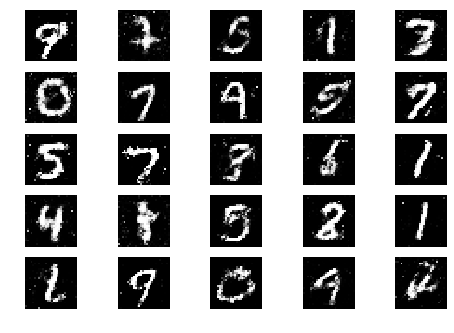

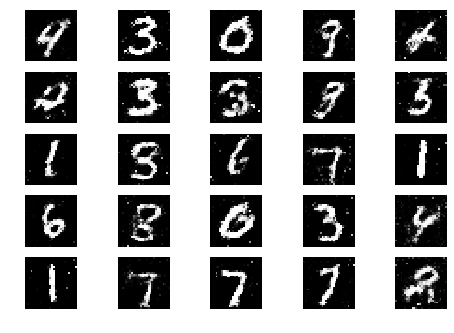

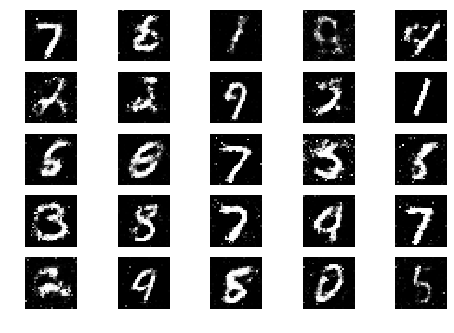

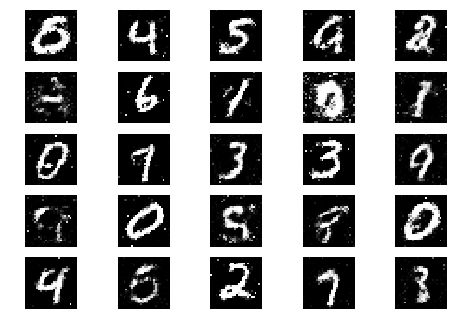

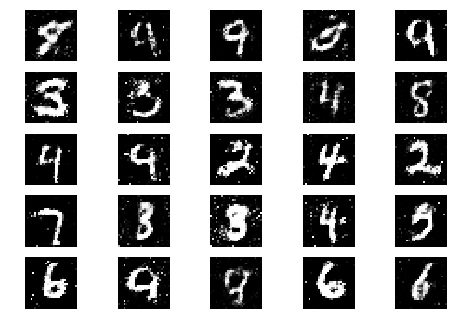

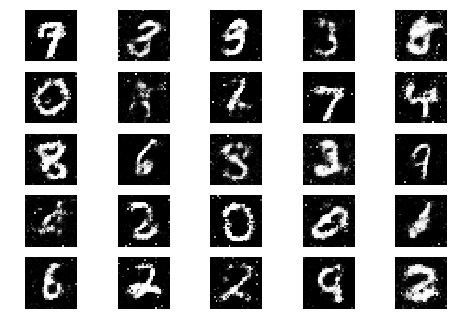

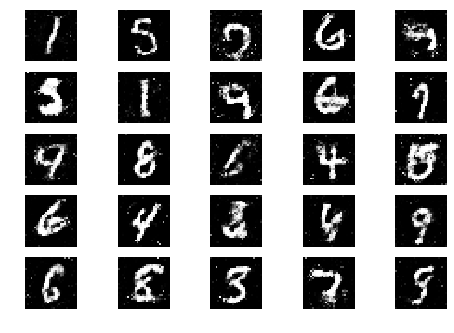

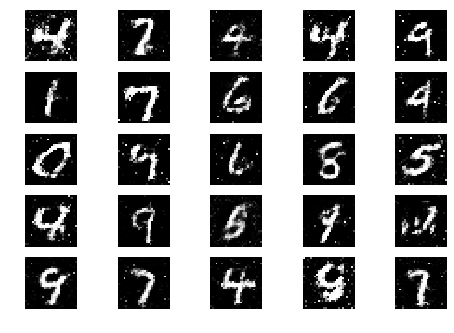

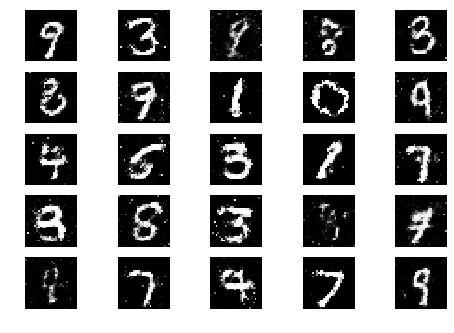

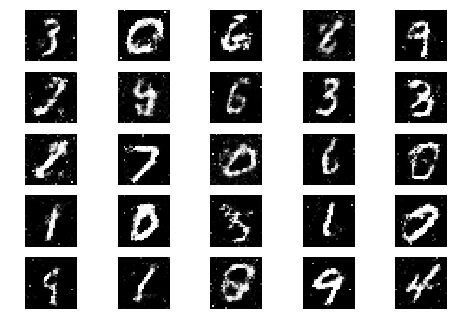

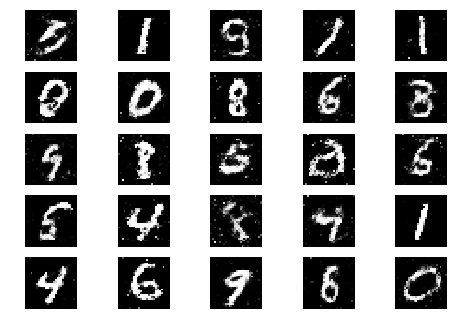

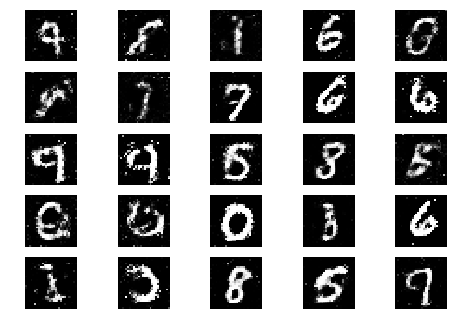

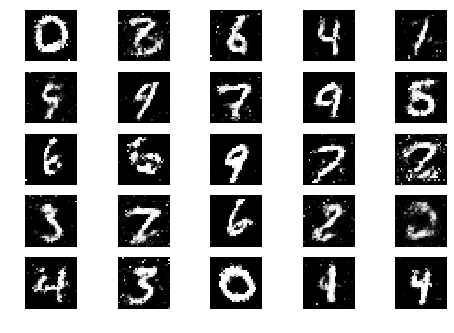

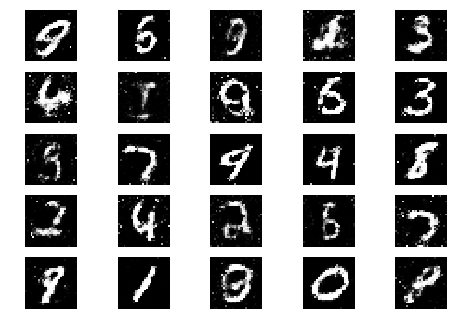

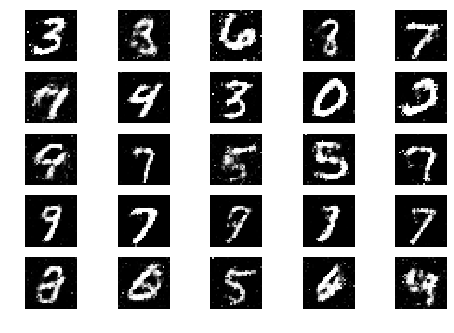

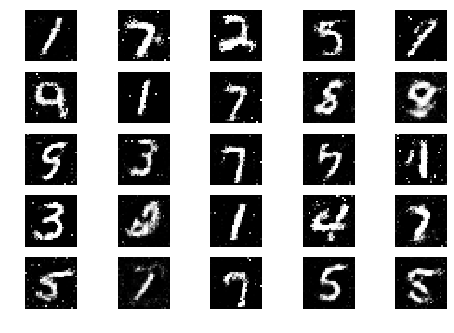

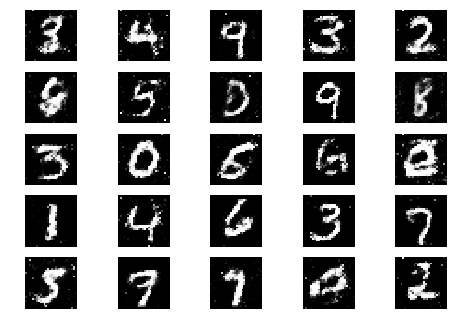

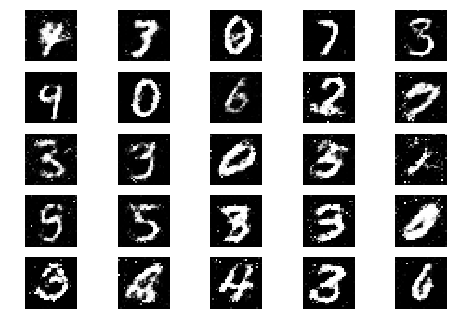

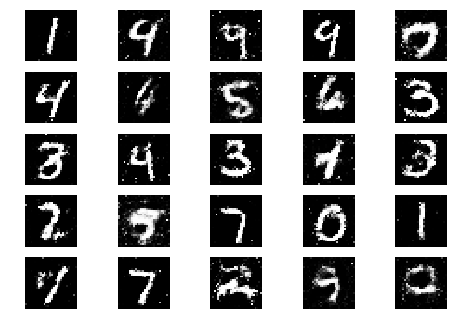

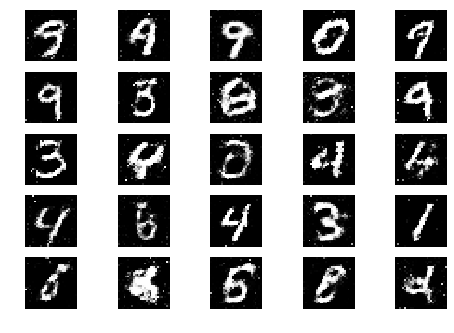

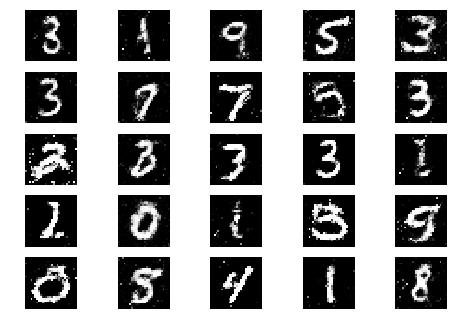

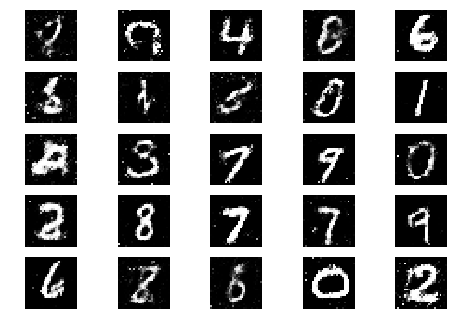

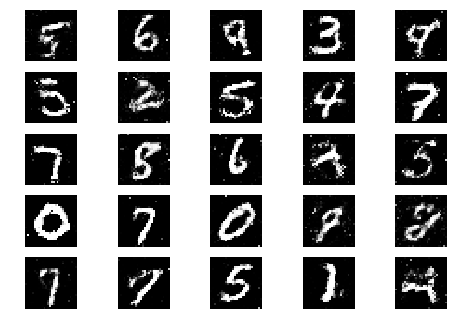

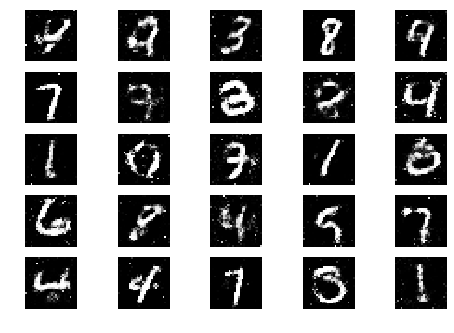

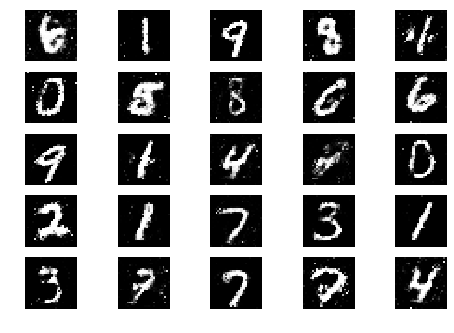

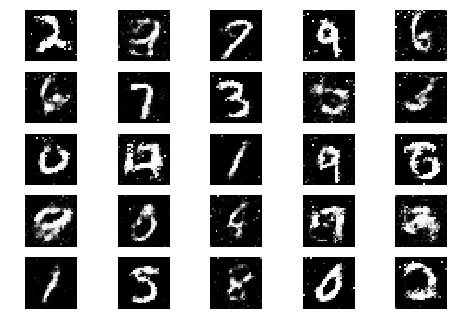

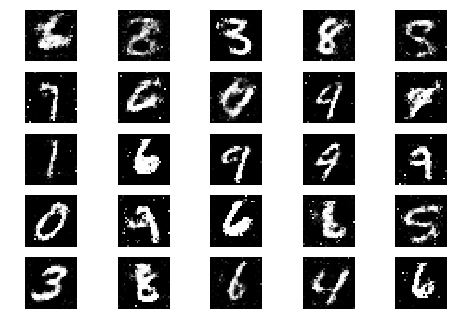

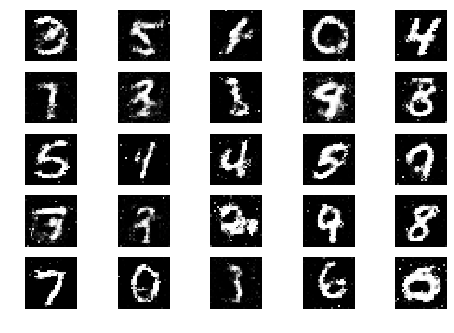

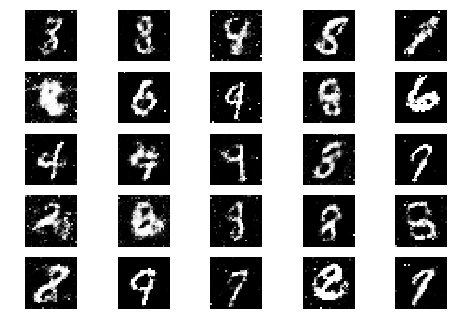

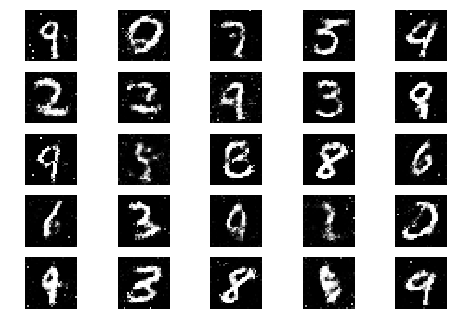

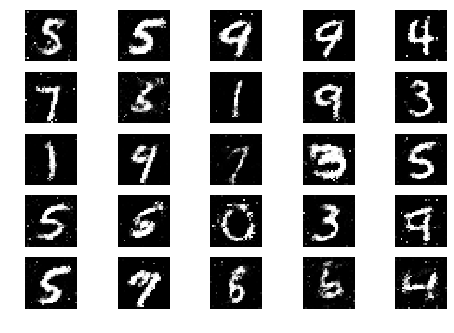

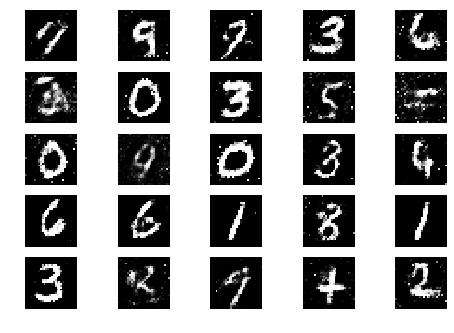

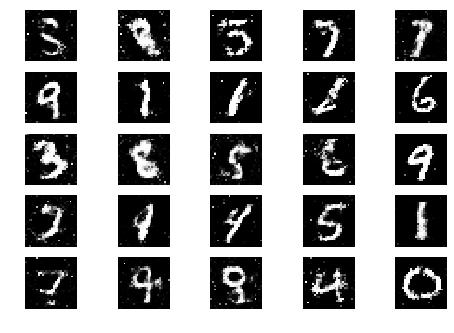

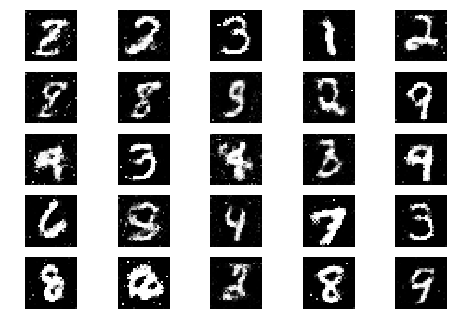

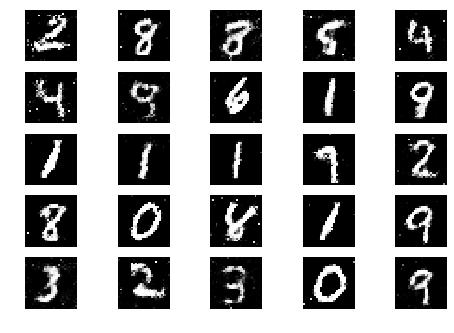

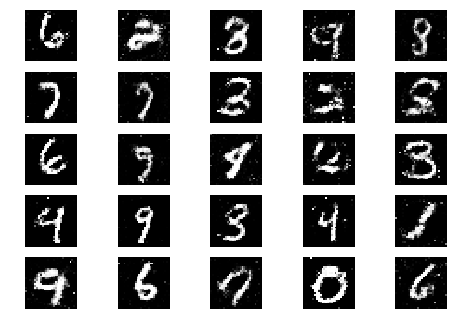

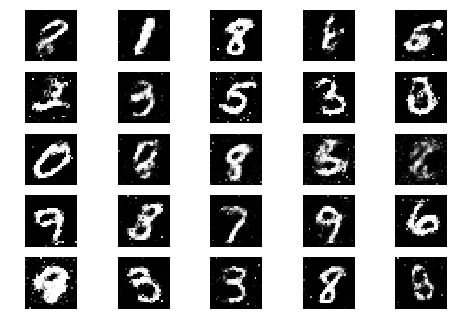

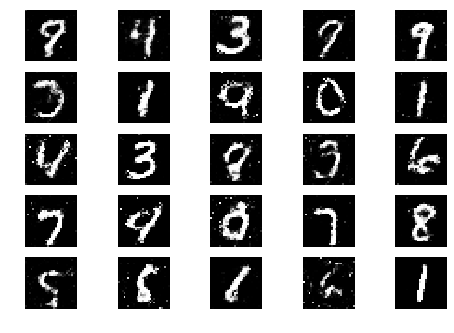

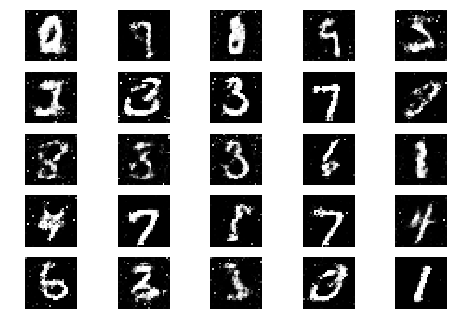

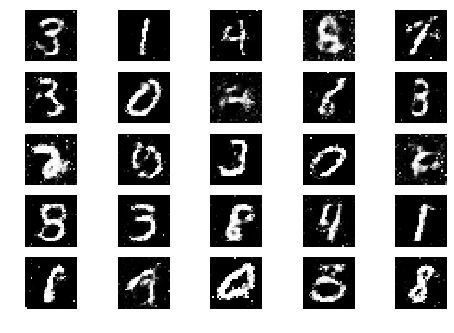

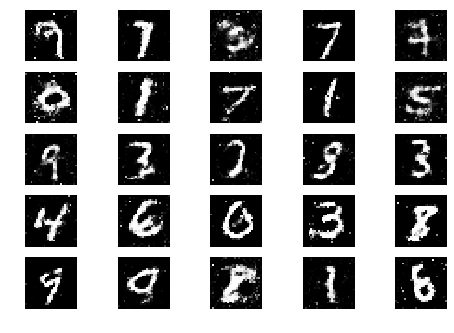

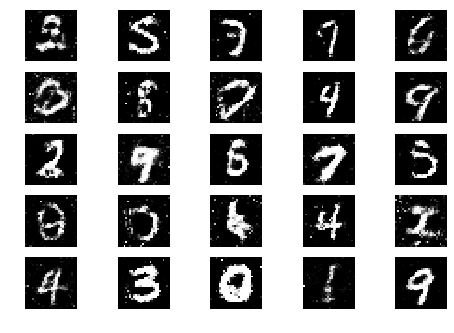

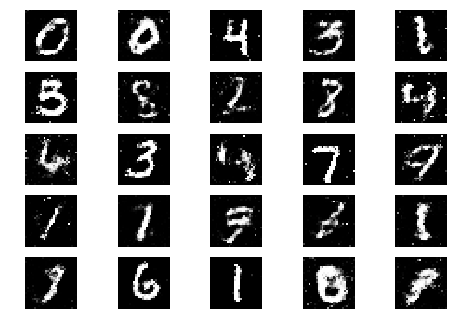

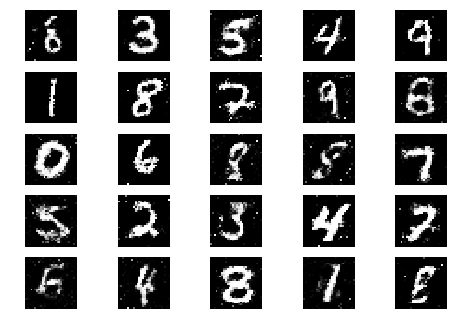

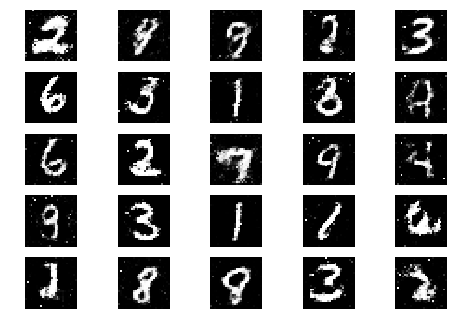

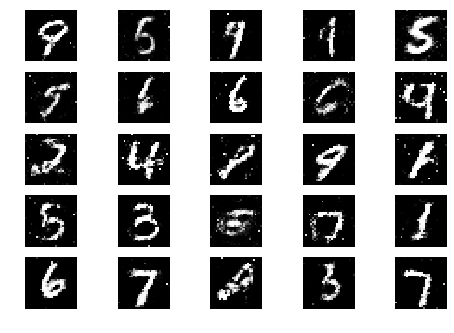

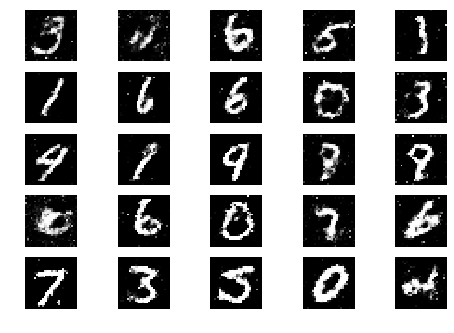

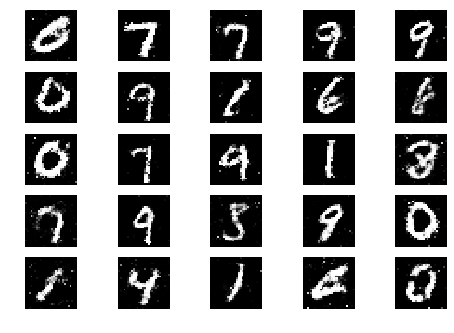

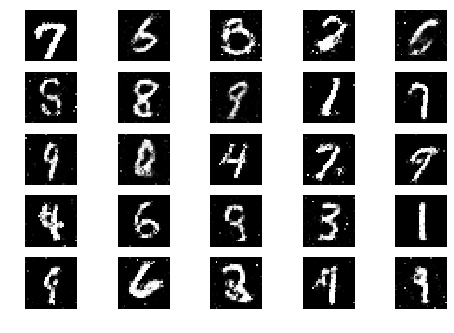

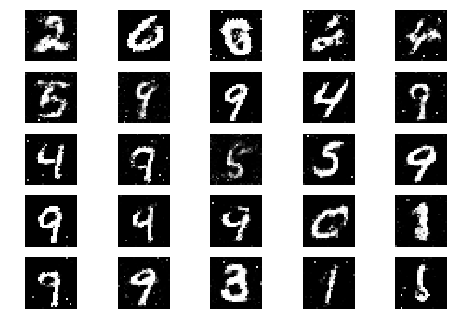

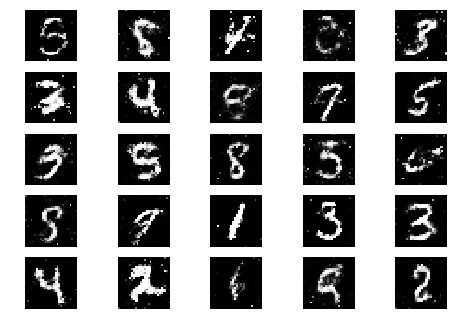

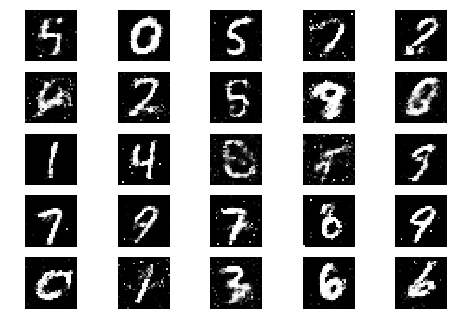

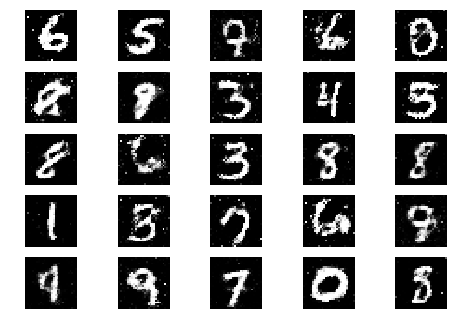

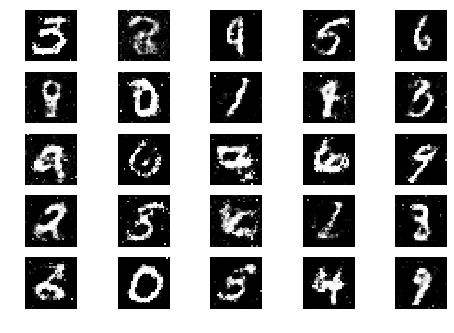

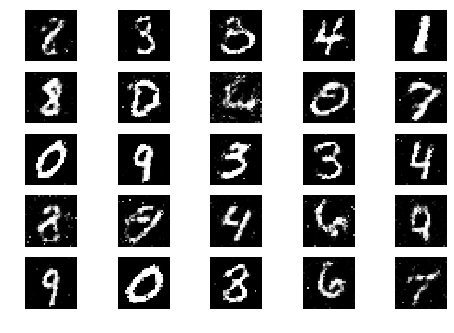

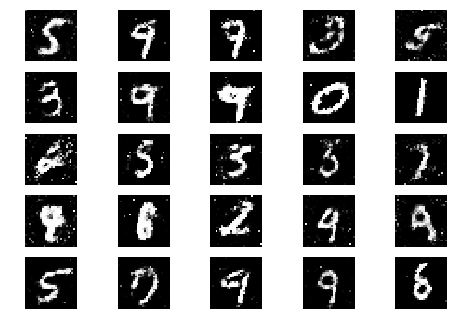

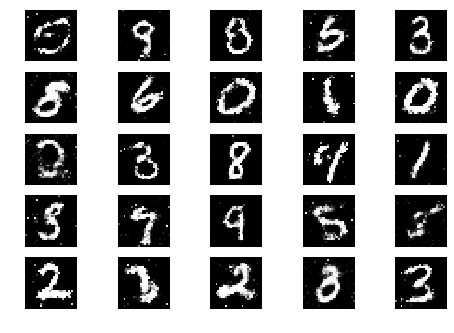

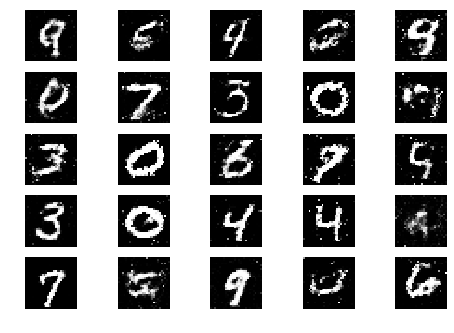

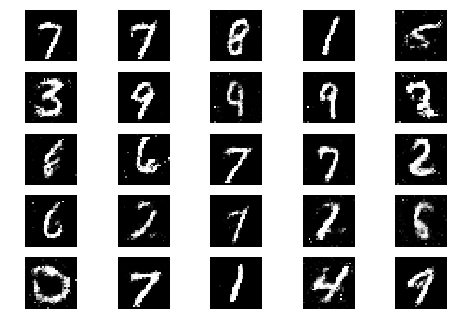

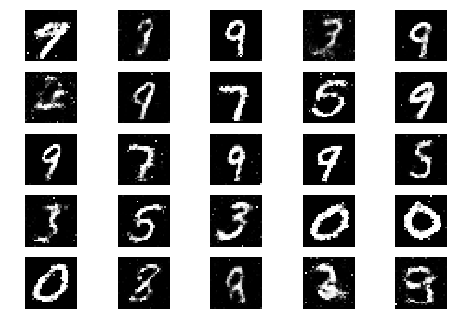

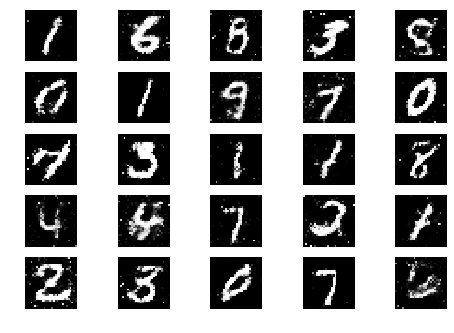

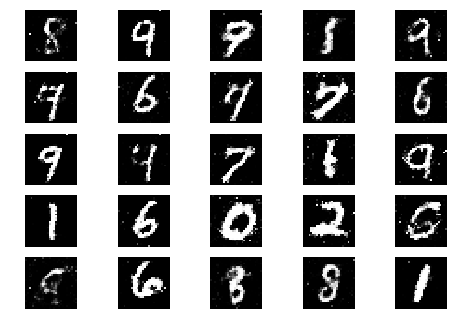

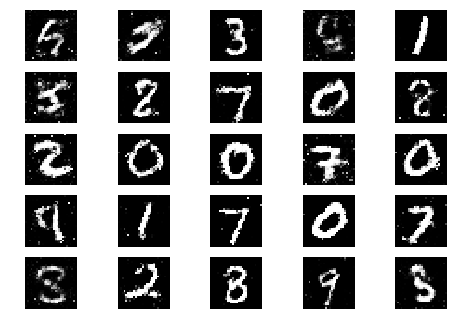

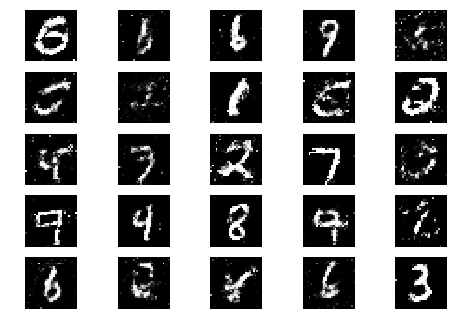

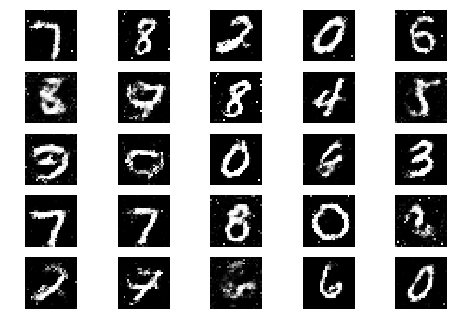

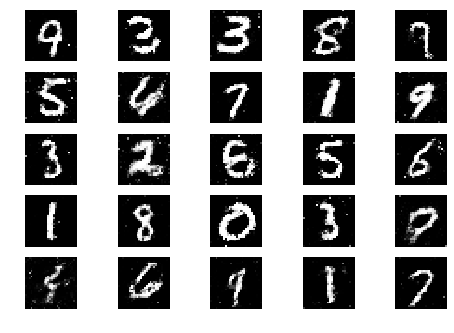

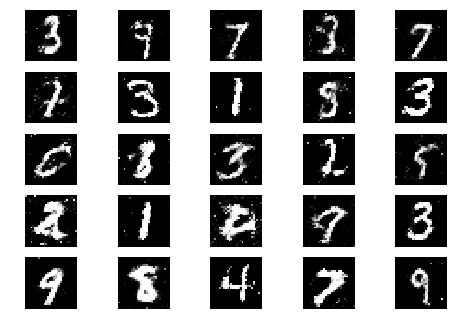

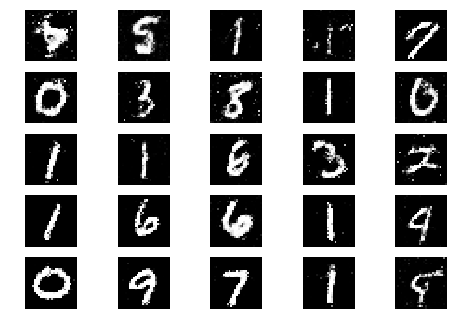

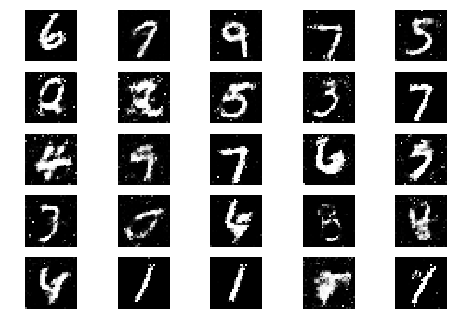

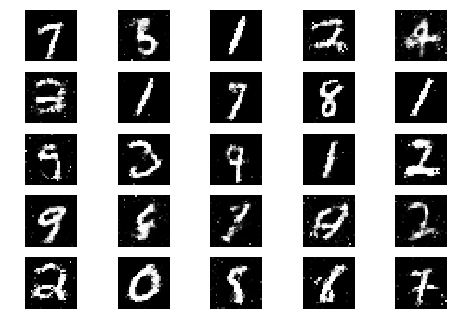

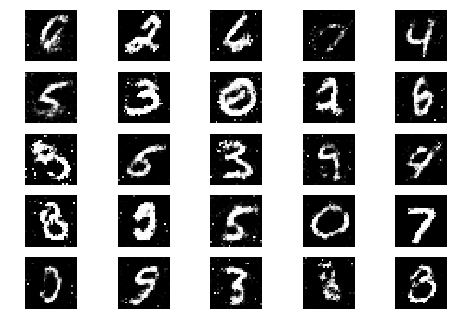

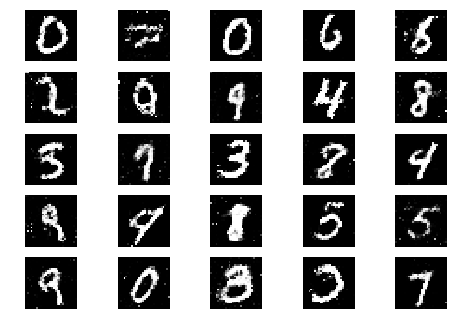

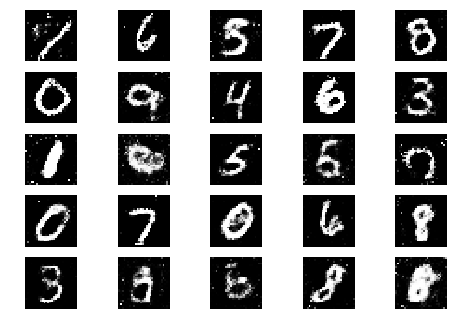

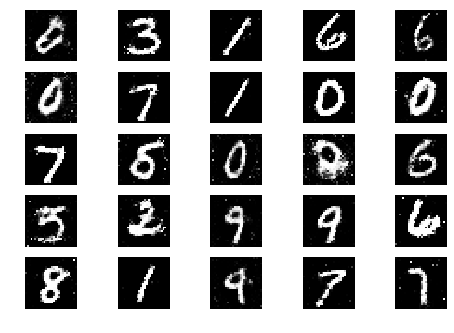

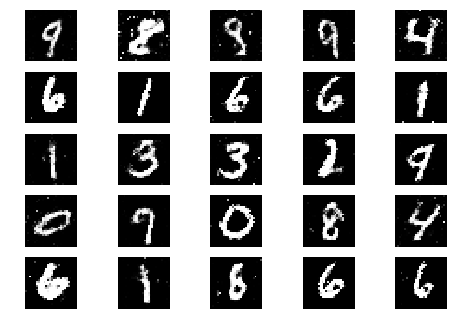

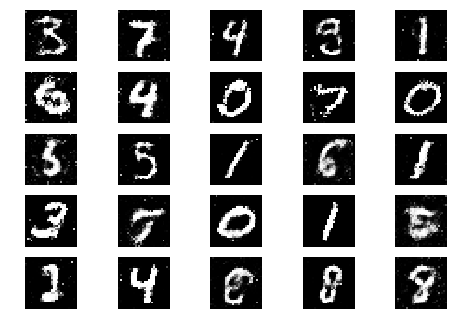

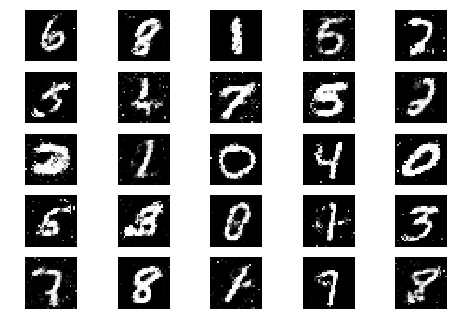

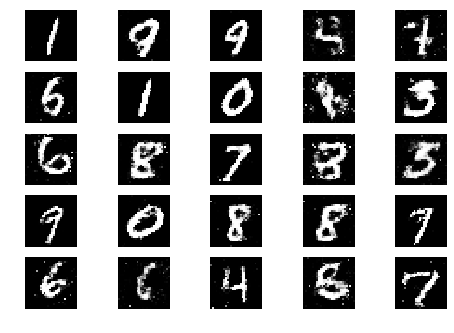

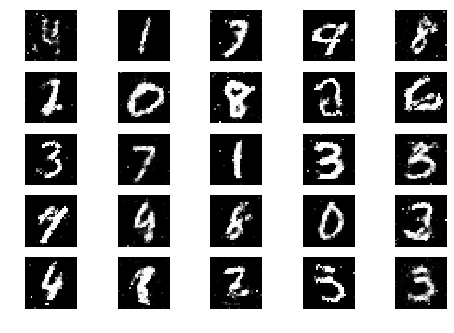

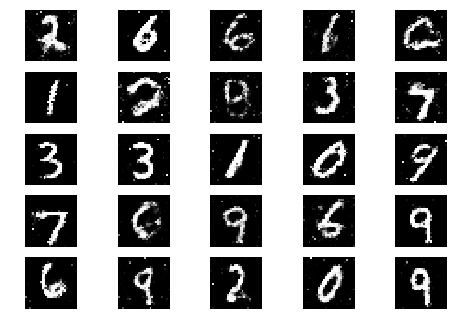

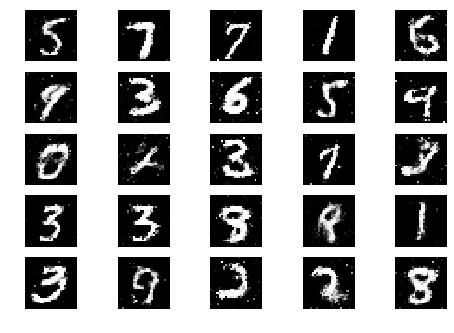

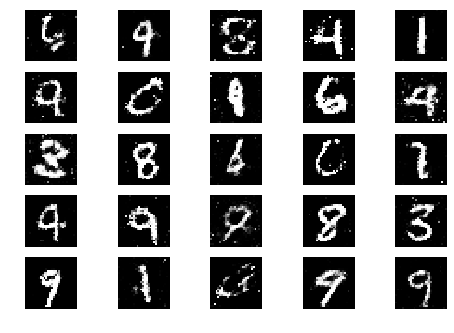

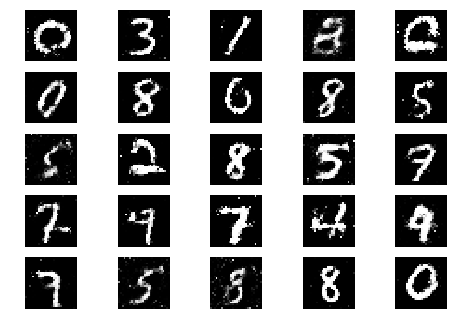

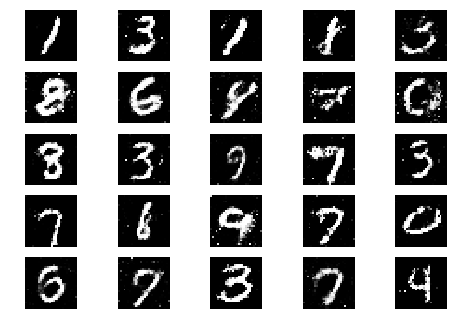

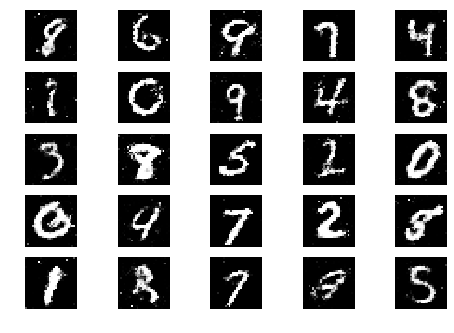

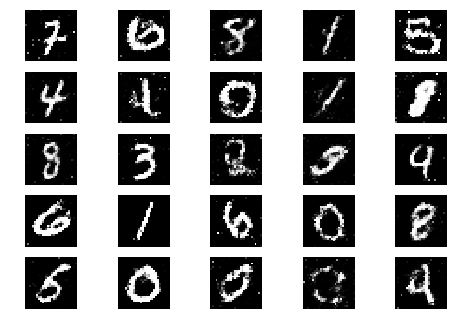

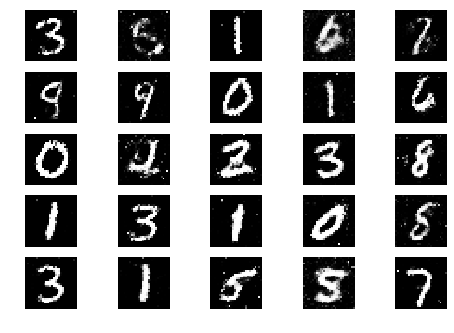

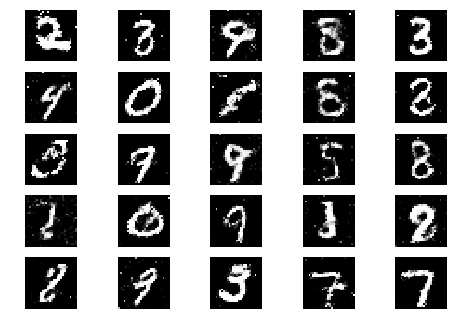

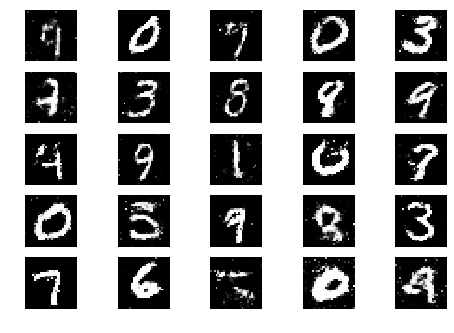

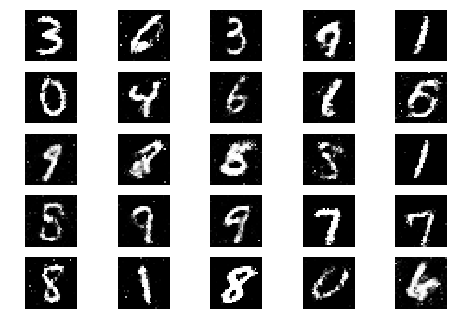

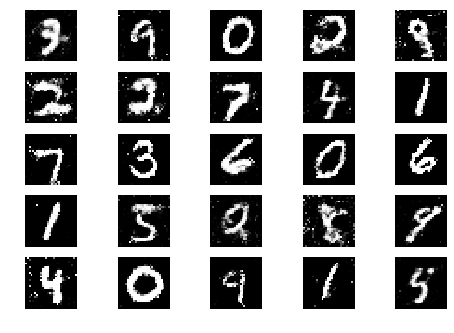

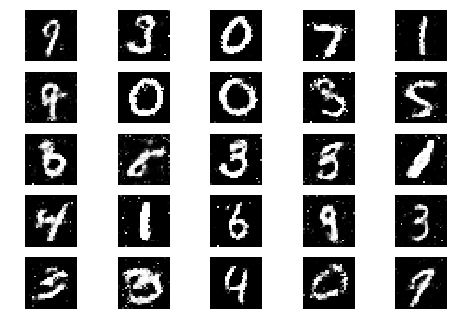

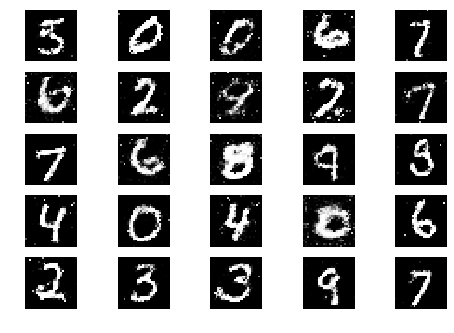

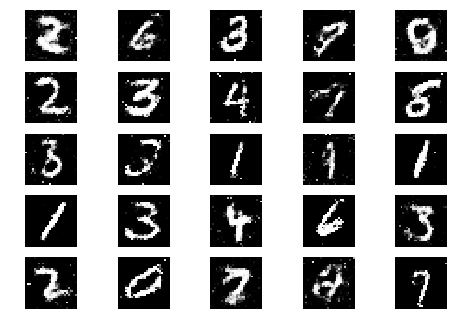

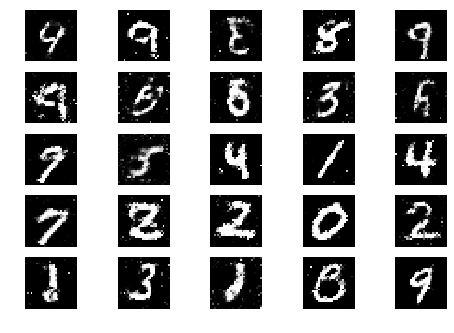

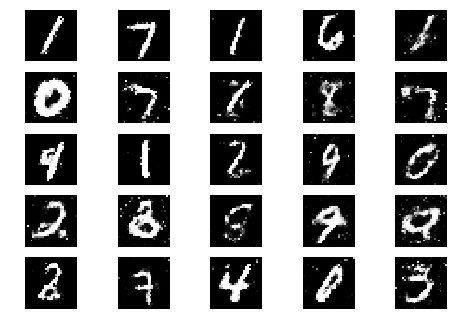

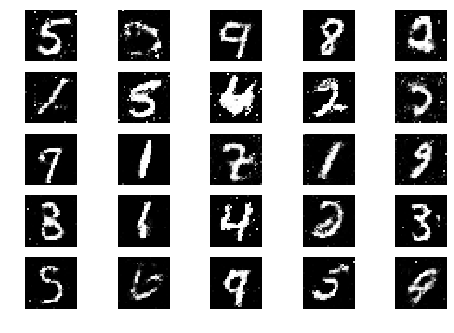

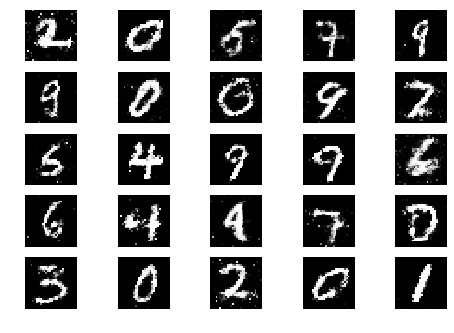

In [6]:
history = gan.fit(
    x_input_train,
    epochs=30000,
    batch_size=32,
    sample_interval=200
)